## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail</a> is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Source
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/online+retail

## Business Goal
To segment the Customers based on RFM so that the company can target its customers efficiently.

## Methodology

1. [Reading and Understanding the Data](#1) <br>
    a. Creating a Data Dictionary
2. [Data Cleaning](#2)
3. [Data Preparation](#3) <br>
    a. Scaling Variables
4. [Model Building](#4) <br>
    a. K-means Clustering <br>
    b. Finding the Optimal K
5. [Final Analysis](#5)

<a id="1"></a> <br>
### 1 : Reading and Understanding Data

In [209]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py 
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [210]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv("OnlineRetail.csv", header = 0, encoding = 'unicode_escape')

#### Data Dictionary 

First Header  | Definition    |  Description  | Data Type
------------- | ------------- | ------------- | -------------
InvoiceNo  | Invoice number | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. | Nominal
StockCode | Product (item) code | A 5-digit integral number uniquely assigned to each distinct product. | Nominal
Description | Product (item) name | Name of Product | Nominal
Quantity | Quantity | The quantities of each product (item) per transaction | Numeric
InvoiceDate | Invoice Date and time | The day and time when each transaction was generated. | Numeric
UnitPrice | Unit price | Product price per unit in sterling. | Numeric
CustomerID | Customer number | A 5-digit integral number uniquely assigned to each customer. | Nominal
Country | Country name | The name of the country where each customer resides. | Nominal

In [211]:
# shape of df
retail.shape

(541909, 8)

In [212]:
# df description
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Possible Errors:
Count:
- Customer ID has nulls,

Min:
- There are negative values

<a id="2"></a> <br>
### 2 : Data Cleaning

### EDA

In [213]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

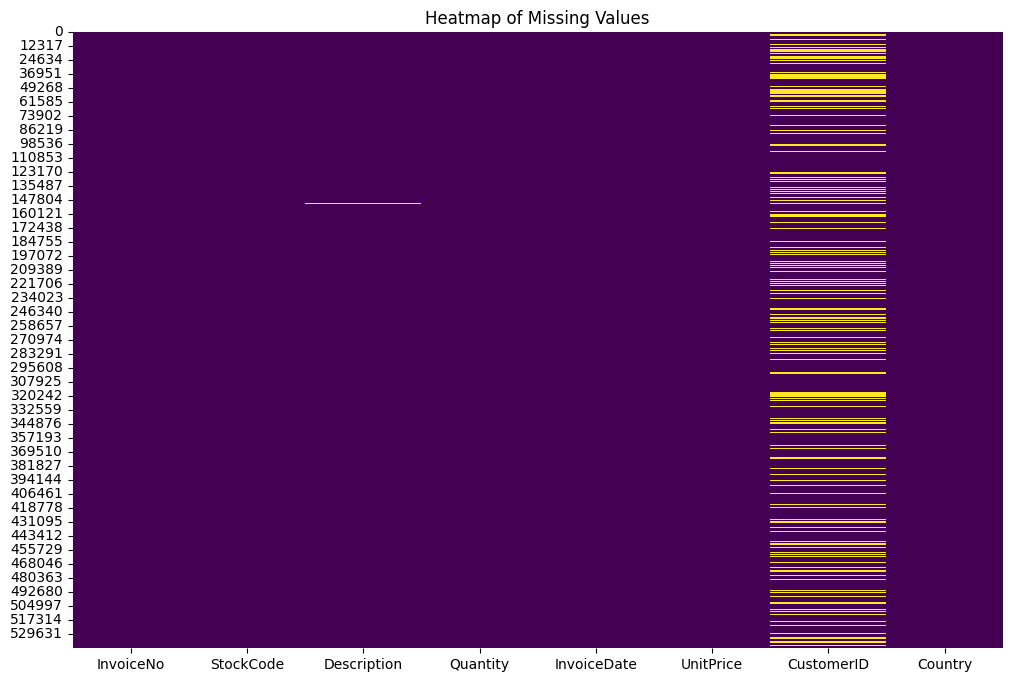

In [214]:
# Heatmap to show the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(retail.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

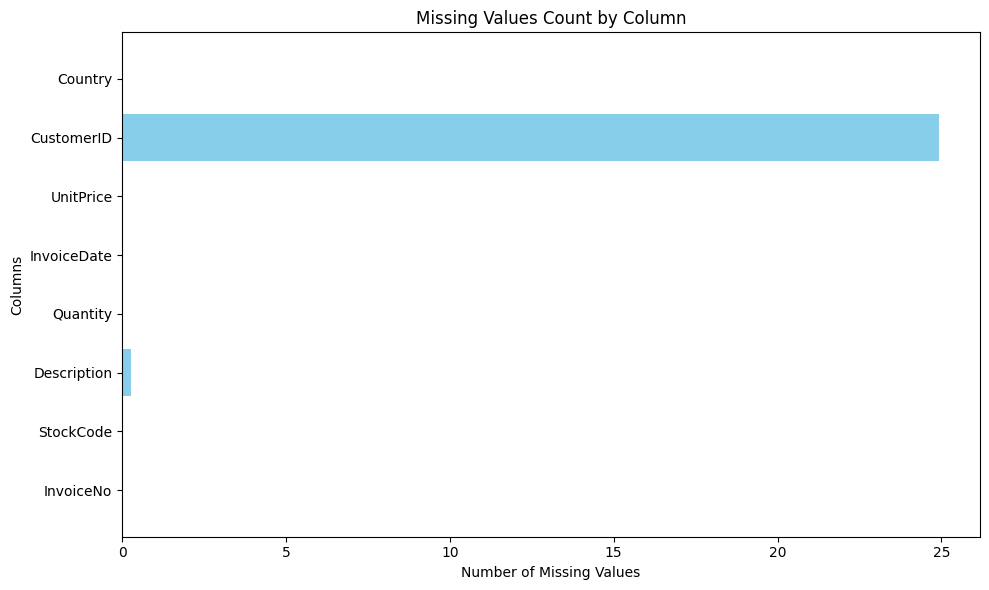

In [215]:
# Plotting the missing values as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_null.index, df_null.values, color='skyblue')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Missing Values Count by Column')
plt.tight_layout()

plt.show()

24.93% of cust.ID have missing values\
27% of Description have missing values

1. Use of Heatmap
- with heatmap, we are able to clearly see how much of the data has nulls in relation to the whole shape of the data. With this, we are able to estimate how much of the data we might lose if we were to drop the null rows.
2. Use of Bar Graph
- as we have seen in the heatmap, there is a small amount of nulls in the description column, to better look at it, it is better to let a bar graph show how much of the data contains nulls.

In [216]:
# Droping rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

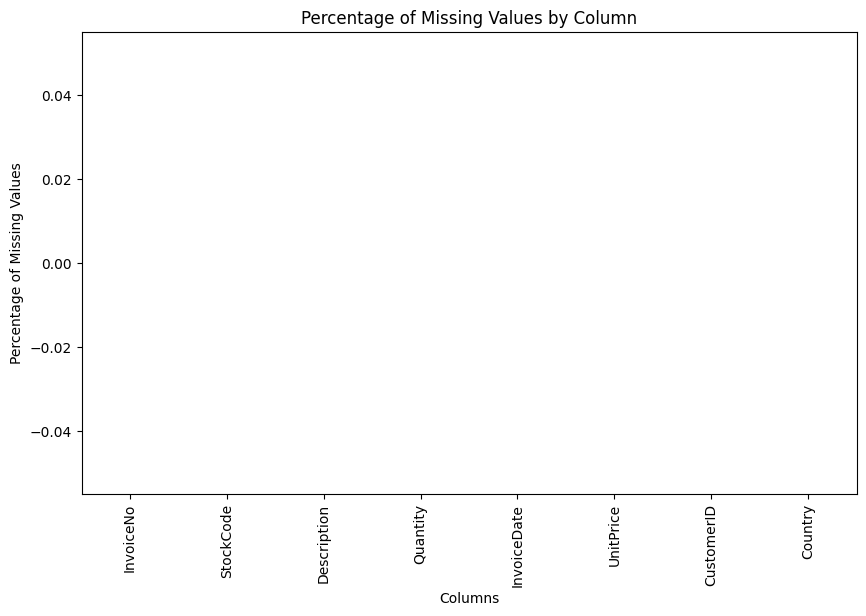

In [217]:
# Calculating the Missing Values % contribution in DF if there are still some left
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

# Bar chart to show if there are still missing values
df_null.plot(kind='bar', figsize=(10, 6))
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.show()

Rows with null values are dropped as seen with the bar graph

In [218]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)

invoice:
There are values with 'C' at the start\
These values mean cancelled transactions so they should be dropped.

In [219]:
# check for negative values on quantity
retail[retail['Quantity'] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,01-12-2010 10:24,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,01-12-2010 10:24,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,01-12-2010 12:38,4.25,17897.0,United Kingdom


In [220]:
# Check for values that do not follow the format of 6 digits
retail['InvoiceNo'] = retail['InvoiceNo'].astype("str")

retail[retail['InvoiceNo'].str.match("^\\d{6}$") == False]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09-12-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09-12-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09-12-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09-12-2011 11:58,1.25,17315.0,United Kingdom


Check for more unique values in InvoiceNo and StockCode

In [221]:
# Display unique values (excluding numbers from 0-9)
retail['InvoiceNo'].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C'], dtype=object)

In [222]:
retail["StockCode"] = retail["StockCode"].astype("str")

retail[(retail["StockCode"].str.match("^\\d{5}$") == False) &
    (retail["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [223]:
# Check for values that will prove to be good for the data
retail[retail["StockCode"].str.contains("^CRUK")]

# Start with D has negative quantity and amount and should be dropped
# Start with CRUK has negative quantity and amount and should be dropped

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317508,C564763,CRUK,CRUK Commission,-1,30-08-2011 10:49,1.60,14096.0,United Kingdom
324023,C565382,CRUK,CRUK Commission,-1,02-09-2011 15:45,13.01,14096.0,United Kingdom
333779,C566216,CRUK,CRUK Commission,-1,09-09-2011 15:17,15.96,14096.0,United Kingdom
338848,C566565,CRUK,CRUK Commission,-1,13-09-2011 12:32,52.24,14096.0,United Kingdom
351003,C567655,CRUK,CRUK Commission,-1,21-09-2011 14:40,608.66,14096.0,United Kingdom
361603,C568345,CRUK,CRUK Commission,-1,26-09-2011 15:28,447.56,14096.0,United Kingdom
372785,C569245,CRUK,CRUK Commission,-1,03-10-2011 09:57,361.59,14096.0,United Kingdom
390002,C570487,CRUK,CRUK Commission,-1,10-10-2011 17:12,411.92,14096.0,United Kingdom
401767,C571440,CRUK,CRUK Commission,-1,17-10-2011 13:31,495.98,14096.0,United Kingdom
416464,C572551,CRUK,CRUK Commission,-1,24-10-2011 17:07,425.14,14096.0,United Kingdom


### Cleaning

In [224]:
retail_cleaned = retail.copy()
retail_cleaned.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [225]:
#invoice number na may mga letter

# convert to string again
retail_cleaned["Invoice"] = retail_cleaned["InvoiceNo"].astype("str")

# choose records that conform with the proper format
mask = retail_cleaned["Invoice"].str.match("^\\d{6}$") == True


retail_cleaned = retail_cleaned[mask]

In [226]:
# 515252 nalang natira
retail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  object 
 7   Country      397924 non-null  object 
 8   Invoice      397924 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 30.4+ MB


only 397924 records left

In [227]:
# StockCode not conforming with the format
# transform muna to string
retail_cleaned["StockCode"] = retail_cleaned["StockCode"].astype("str")


mask = (
    # digit with 5 numbers
    (retail_cleaned["StockCode"].str.match("^\\d{5}$") == True)
    # digit with 5 numbers and ending with letters
    | (retail_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    ) & (
        # exclude codes starting with 'D'
        ~retail_cleaned["StockCode"].str.startswith("D")
    ) & (
        # exclude codes starting with 'CRUK'
        ~retail_cleaned["StockCode"].str.startswith("CRUK")
    )

retail_cleaned = retail_cleaned[mask]

In [228]:
retail_cleaned[retail_cleaned["UnitPrice"] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,05-12-2010 14:02,0.0,12647.0,Germany,537197
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,16-12-2010 14:36,0.0,16560.0,United Kingdom,539263
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,21-12-2010 13:45,0.0,14911.0,EIRE,539722
47068,540372,22090,PAPER BUNTING RETROSPOT,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,540372
47070,540372,22553,PLASTERS IN TIN SKULLS,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,540372
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,13-01-2011 15:10,0.0,15107.0,United Kingdom,541109
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,10-02-2011 13:08,0.0,17560.0,United Kingdom,543599
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,23-03-2011 10:25,0.0,13239.0,United Kingdom,547417
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,30-03-2011 12:45,0.0,13113.0,United Kingdom,548318
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,04-04-2011 14:42,0.0,14410.0,United Kingdom,548871


There are many prices equal to 0 and should be dropped as it does not make sense

In [229]:
retail_cleaned = retail_cleaned[retail_cleaned["UnitPrice"] > 0.0]
retail_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,536365
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,536365
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,536365
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,536365
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,536365
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France,581587
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France,581587
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France,581587
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France,581587


In [230]:
retail_cleaned.describe()

,Quantity,UnitPrice
count,396337.000000,396337.000000
mean,13.012547,2.868222
std,179.641245,4.264663
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


In [231]:
# 396337 left.
# 1, 587 records were removed
retail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396337 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    396337 non-null  object 
 1   StockCode    396337 non-null  object 
 2   Description  396337 non-null  object 
 3   Quantity     396337 non-null  int64  
 4   InvoiceDate  396337 non-null  object 
 5   UnitPrice    396337 non-null  float64
 6   CustomerID   396337 non-null  object 
 7   Country      396337 non-null  object 
 8   Invoice      396337 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 30.2+ MB


In [232]:
retail_cleaned.describe()
# we still have negative quantities. Price ok naman.
# we will also remove the 0, kasi ibig sabihin wala binili yan

,Quantity,UnitPrice
count,396337.000000,396337.000000
mean,13.012547,2.868222
std,179.641245,4.264663
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


In [233]:
retail_cleaned.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Invoice
count,396337,396337,396337,396337,396337,396337,396337
unique,18402,3659,3871,17166,4334,37,18402
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,14-11-2011 15:27,17841.0,United Kingdom,576339
freq,541,2035,2028,541,7838,353985,541


All columns are now cleaned

<a id="3"></a> <br>
### 3 : Data Preparation

#### Customers will be analyzed based on 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [234]:
# New Attribute : Monetary
retail_cleaned['Amount'] = retail_cleaned['Quantity'] * retail_cleaned['UnitPrice']
# same customer ids are grouped (amount col is summed up)
rfm_m = retail_cleaned.groupby('CustomerID')['Amount'].sum()

# set default index for new dframe
rfm_m = rfm_m.reset_index()

rfm_m.head(5)

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


In [235]:
# New Attribute : Frequency
# count number of invoice (no. of times they purchased something)
rfm_f = retail_cleaned.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()

#rename InvoiceNo col to frequency
rfm_f.columns = ['CustomerID', 'Frequency']

rfm_f.head(5)

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,27
3,12349.0,72
4,12350.0,16


In [236]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
print(rfm.shape)
rfm.head(5)


(4334, 3)


,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1437.24,27
3,12349.0,1457.55,72
4,12350.0,294.40,16


There are 4334 unique customers based on the shape

In [237]:
# New Attribute : Recency

# Convert to datetime to proper datatype
retail_cleaned['InvoiceDate'] = pd.to_datetime(retail_cleaned['InvoiceDate'], format = '%d-%m-%Y %H:%M')

In [238]:
# To compute for recency:
# Compute the maximum date to know the last transaction date
max_date = max(retail_cleaned['InvoiceDate'])
max_date


Timestamp('2011-12-09 12:50:00')

In [239]:
# Compute the difference between max date and transaction date
retail_cleaned['Diff'] = max_date - retail_cleaned['InvoiceDate']
retail_cleaned.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice,Amount,Diff
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,581587,10.20,0 days
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,581587,12.60,0 days
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,581587,16.60,0 days
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,581587,16.60,0 days
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,581587,14.85,0 days


In [240]:
# Compute last transaction date to get the recency of customers
rfm_p = retail_cleaned.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [241]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [242]:
# Merge the dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')

# name Diff to Recency for RFM
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']

rfm.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1437.24,27,74
3,12349.0,1457.55,72,18
4,12350.0,294.40,16,309


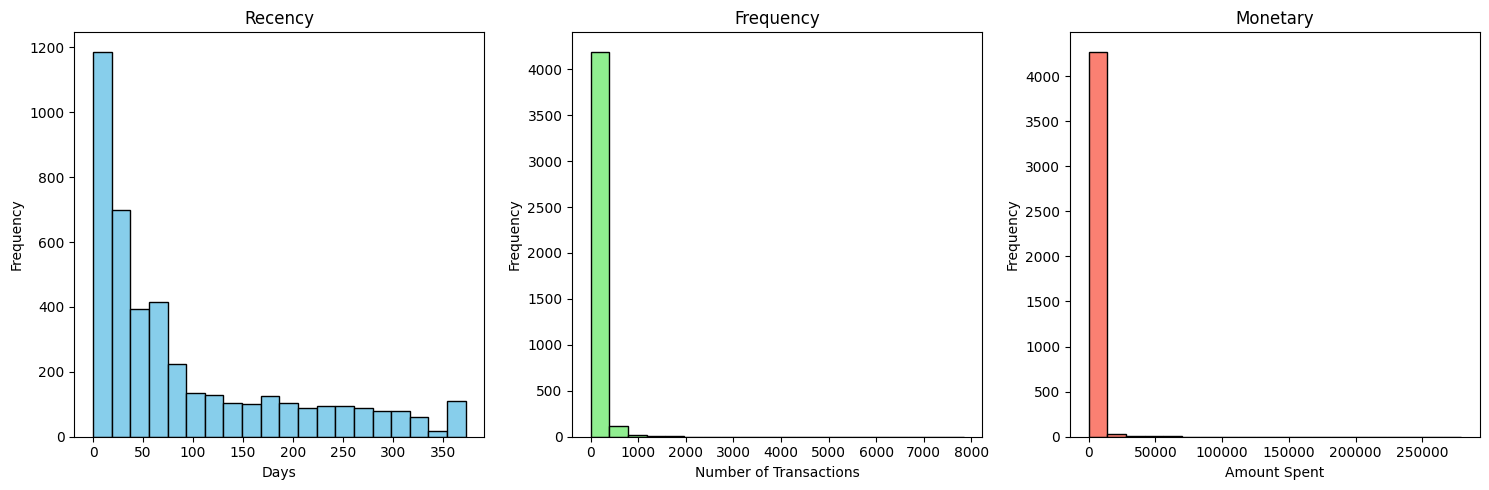

In [243]:
# Plotting histograms for RFM variables
plt.figure(figsize=(15, 5))

# Histogram for Recency
plt.subplot(1, 3, 1)
plt.hist(rfm['Recency'], bins=20, color='skyblue', edgecolor='black')
plt.title('Recency')
plt.xlabel('Days')
plt.ylabel('Frequency')

# Histogram for Frequency
plt.subplot(1, 3, 2)
plt.hist(rfm['Frequency'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Frequency')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')

# Histogram for Monetary
plt.subplot(1, 3, 3)
plt.hist(rfm['Amount'], bins=20, color='salmon', edgecolor='black')
plt.title('Monetary')
plt.xlabel('Amount Spent')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

1. Use of histogram:
- show distribution of values for rfm

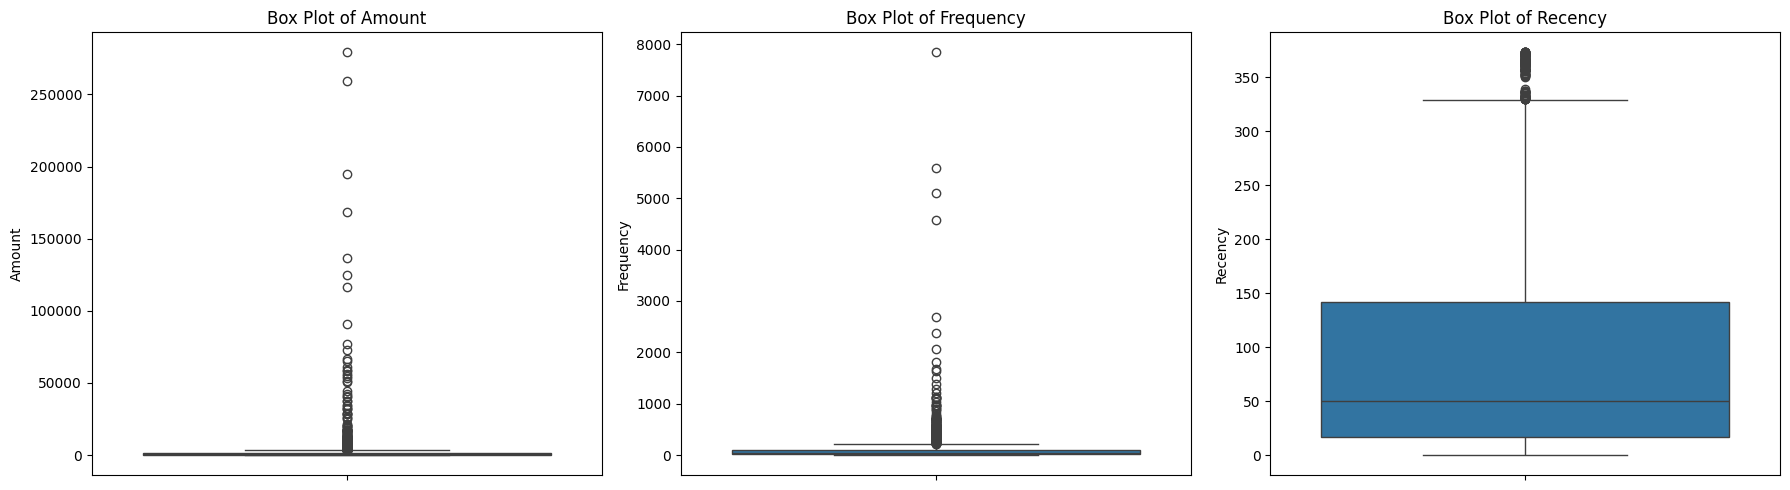

Number of outliers in Amount: 217
              Amount    Frequency     Recency
count     217.000000   217.000000  217.000000
mean    20328.625300   479.069124   20.894009
std     34827.726503   840.758195   41.578939
min      5756.890000     1.000000    0.000000
25%      6911.440000   139.000000    2.000000
50%      9341.260000   305.000000    8.000000
75%     16363.230000   458.000000   22.000000
max    279138.020000  7838.000000  325.000000
Number of outliers in Frequency: 217
              Amount    Frequency     Recency
count     217.000000   217.000000  217.000000
mean    13814.887419   645.115207   13.940092
std     33199.110796   798.713509   20.732447
min      1052.550000   315.000000    0.000000
25%      3089.970000   364.000000    2.000000
50%      5630.870000   440.000000    7.000000
75%      9743.110000   589.000000   18.000000
max    279138.020000  7838.000000  155.000000
Number of outliers in Recency: 212
             Amount   Frequency     Recency
count    212.000000  2

In [244]:
# Box plots to identify outliers in Amount, Frequency, and Recency
plt.figure(figsize=(18, 5))

# Box plot for Amount
plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['Amount'])
plt.title('Box Plot of Amount')

# Box plot for Frequency
plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['Frequency'])
plt.title('Box Plot of Frequency')

# Box plot for Recency
plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['Recency'])
plt.title('Box Plot of Recency')

plt.tight_layout()
plt.show()


# Insights on outliers
# Amount outliers
amount_outliers = rfm[rfm['Amount'] > rfm['Amount'].quantile(0.95)]
print(f"Number of outliers in Amount: {amount_outliers.shape[0]}")
print(amount_outliers.describe())

# Frequency outliers
frequency_outliers = rfm[rfm['Frequency'] > rfm['Frequency'].quantile(0.95)]
print(f"Number of outliers in Frequency: {frequency_outliers.shape[0]}")
print(frequency_outliers.describe())

# Recency outliers
recency_outliers = rfm[rfm['Recency'] > rfm['Recency'].quantile(0.95)]
print(f"Number of outliers in Recency: {recency_outliers.shape[0]}")
print(recency_outliers.describe())

# As you can see in the boxplot, there are outliers in the data. So, we need to scale the data before we proceed with modeling.


2. Use of Boxplot:
- check the distributions of values
- check average of values (median)
- see if there are outliers in the data

and from the boxplot, the boxplots for frequency and monetary are squished. Additionally, there are a lot of outliers in the data which could mean that these data may need to have their own classification rather than them being dropped. 

In [245]:
M_Q1 = rfm["Amount"].quantile(0.25)
M_Q3 = rfm["Amount"].quantile(0.75)

A_IQR = M_Q3 - M_Q1

monetary_outliers = rfm[
    (rfm["Amount"] > (M_Q3 + 1.5 * A_IQR)) \
        | (rfm["Amount"] < (M_Q3 - 1.5 * A_IQR))
].copy()
amount_outliers

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
10,12357.0,6207.67,131,32
12,12359.0,6372.58,248,57
50,12409.0,11072.67,109,78
55,12415.0,124564.53,713,23
...,...,...,...,...
4202,18109.0,8052.97,444,1
4224,18139.0,8438.34,159,17
4248,18172.0,7561.68,189,14
4287,18223.0,6484.54,272,4


In [246]:
monetary_outliers.describe()

,Amount,Frequency,Recency
count,425.000000,425.000000,425.000000
mean,12568.004141,371.221176,24.724706
std,26097.899415,625.214347,47.076383
min,3622.680000,1.000000,0.000000
25%,4359.320000,149.000000,3.000000
50%,5891.610000,249.000000,10.000000
75%,9430.520000,399.000000,23.000000
max,279138.020000,7838.000000,371.000000


In [247]:
F_Q1 = rfm["Frequency"].quantile(0.25)
F_Q3 = rfm["Frequency"].quantile(0.75)

F_IQR = F_Q3 - F_Q1

frequency_outliers = rfm[
    (rfm["Frequency"] > (F_Q3 + 1.5 *F_IQR)) \
        | (rfm["Frequency"] < (F_Q3 - 1.5 * F_IQR))
].copy()
frequency_outliers

,CustomerID,Amount,Frequency,Recency
12,12359.0,6372.58,248,57
15,12362.0,4737.23,256,2
55,12415.0,124564.53,713,23
66,12428.0,6405.26,287,25
69,12431.0,6382.45,233,35
...,...,...,...,...
4213,18122.0,1824.99,362,7
4287,18223.0,6484.54,272,4
4289,18225.0,5509.12,271,2
4290,18226.0,5228.05,242,43


In [248]:
frequency_outliers.describe()

,Amount,Frequency,Recency
count,376.000000,376.000000,376.000000
mean,10155.972128,484.890957,18.941489
std,26108.887909,634.720450,31.263811
min,620.040000,225.000000,0.000000
25%,2582.050000,272.000000,3.000000
50%,4483.430000,336.000000,9.000000
75%,7141.290000,470.000000,23.000000
max,279138.020000,7838.000000,371.000000


In [249]:
non_outliers_df = rfm[(~rfm.index.isin(amount_outliers.index)) & (~rfm.index.isin(frequency_outliers.index))]

non_outliers_df.describe()

,Amount,Frequency,Recency
count,3875.000000,3875.000000,3875.000000
mean,924.000361,52.807226,99.952000
std,965.038197,50.239558,101.984983
min,3.750000,1.000000,0.000000
25%,279.410000,15.000000,21.000000
50%,572.950000,34.000000,58.000000
75%,1210.380000,76.000000,160.500000
max,5719.820000,224.000000,373.000000


Text(0.5, 0, 'Recency')

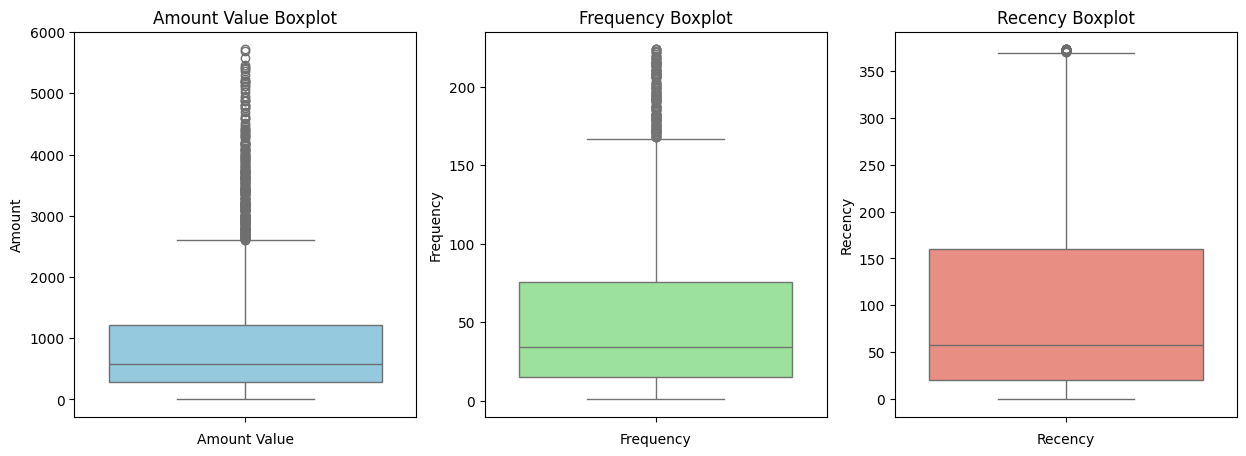

In [250]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['Amount'], color='skyblue')
plt.title('Amount Value Boxplot')
plt.xlabel('Amount Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

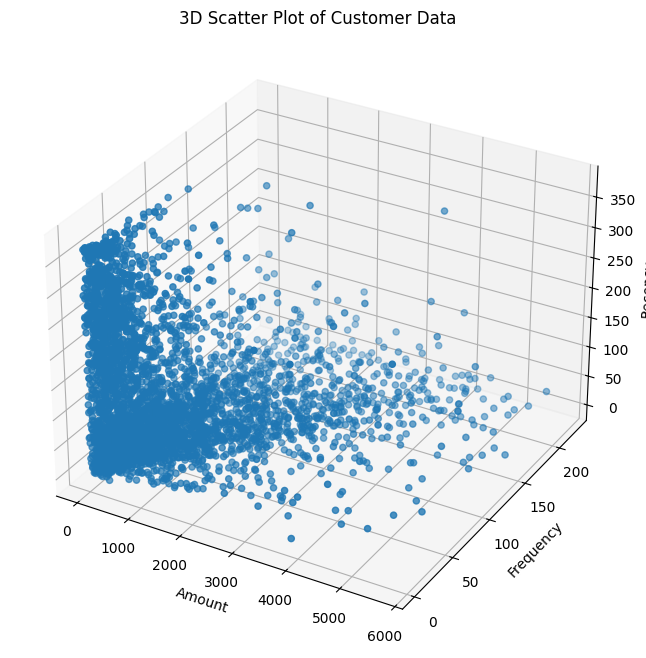

In [251]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df['Amount'], non_outliers_df['Frequency'], non_outliers_df['Recency'])

ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

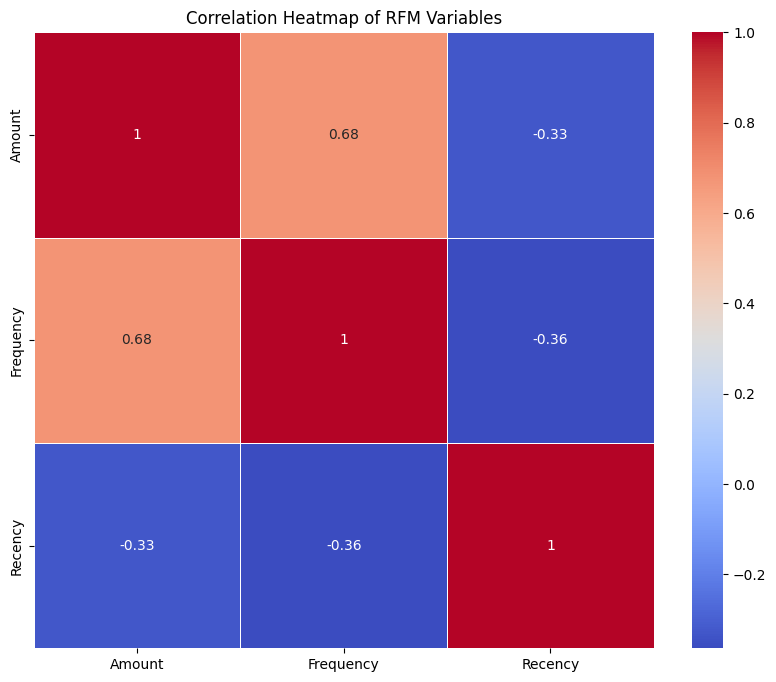

In [252]:
# Compute the correlation matrix excluding CustomerID
correlation_matrix = non_outliers_df.drop(columns=['CustomerID']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of RFM Variables')
plt.show()

# As you can see, the correlation between Amount and Frequency is 0.86, which is high.
# The correlation between Amount and Recency is -0.28, which is low.
# The correlation between Frequency and Recency is -0.48, which is low.
# The variables are not highly correlated, so we can proceed with clustering.

#### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.<br>
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardization (mean-0, sigma-1) 

Here we execute Standard Scaling.

In [253]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[['Amount', 'Frequency', 'Recency']])

scaled_data

array([[ 3.50912185,  2.57186674, -0.97038571],
       [ 0.53190213, -0.51374967, -0.25450168],
       [ 0.55295065,  0.38207445, -0.80367299],
       ...,
       [-0.87384021, -0.91189373,  0.78500117],
       [-0.77307472, -0.81235771, -0.91154593],
       [ 0.94648845,  0.34226004, -0.56831386]])

In [254]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=('Amount', 'Frequency', 'Recency'))

scaled_data_df

,Amount,Frequency,Recency
1,3.509122,2.571867,-0.970386
2,0.531902,-0.513750,-0.254502
3,0.552951,0.382074,-0.803673
4,-0.652494,-0.732729,2.050057
5,0.478529,0.481610,-0.636960
...,...,...,...
4328,-0.777376,-0.872079,-0.264308
4329,-0.770432,-0.852172,1.736244
4330,-0.873840,-0.911894,0.785001
4331,-0.773075,-0.812358,-0.911546


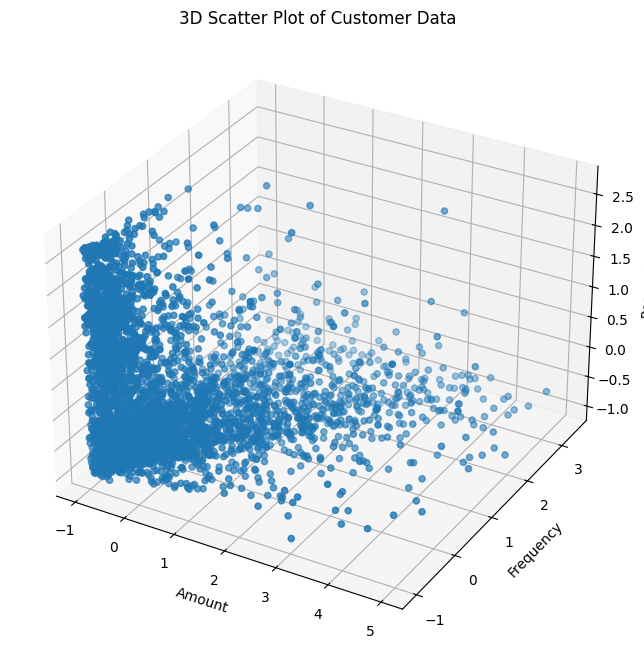

In [255]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df['Amount'], scaled_data_df['Frequency'], scaled_data_df['Recency'])

ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

### As you can see above, the data is now scaled and ready for clustering.
Equal Weightage: Different features in your dataset might have different units and scales. For example, one feature could be in the range of 0-1, while another could be in the range of 0-1000. Without scaling, features with larger ranges will dominate the distance calculations, leading to biased clustering results.

Distance Metrics: Many clustering algorithms, such as K-Means, rely on distance metrics (like Euclidean distance) to form clusters. These metrics are sensitive to the magnitude of the features. Scaling ensures that each feature contributes equally to the distance computation.

Algorithm Performance: Properly scaled data can improve the performance and convergence speed of clustering algorithms.

## <span style="color: red;">Execute MinMax Scaling in the next box</span> 

In [256]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate
minmax_scaler = MinMaxScaler()

# Fit and transform
rfm_df_minmax_scaled = minmax_scaler.fit_transform(scaled_data_df)
rfm_df_minmax_scaled = pd.DataFrame(rfm_df_minmax_scaled, columns=['Amount', 'Frequency', 'Recency'])
rfm_df_minmax_scaled.head(5)

,Amount,Frequency,Recency
0,0.753359,0.811659,0.002681
1,0.250782,0.116592,0.198391
2,0.254336,0.318386,0.048257
3,0.050848,0.067265,0.828418
4,0.241773,0.340807,0.093834


<a id="4"></a> <br>
### 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

## <span style="color: red;">Finding the Optimal Number of Clusters</span> 

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

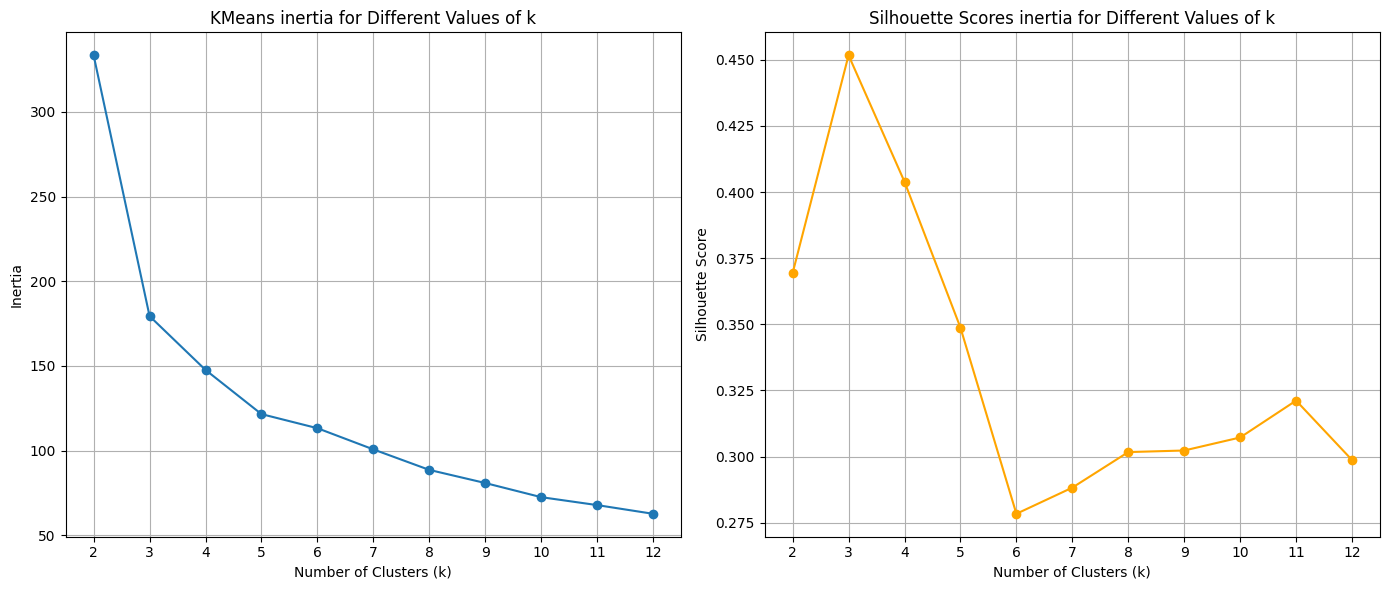

In [258]:
max_k = 12

intertia = []
silhouette_scores = []
k_values = range(2, max_k +1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(rfm_df_minmax_scaled)
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    silhouette_scores.append(sil_score)
    intertia.append(kmeans.inertia_)
    
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, intertia, marker='o')
plt.title('KMeans inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()


In [259]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(rfm_df_minmax_scaled)
cluster_labels

array([0, 1, 2, ..., 3, 1, 2])

In [260]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

C:\Users\Luke Santibanez\AppData\Local\Temp\ipykernel_15648\1071184375.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CustomerID,Amount,Frequency,Recency,Cluster
1,12347.0,4310.00,182,1,0
2,12348.0,1437.24,27,74,1
3,12349.0,1457.55,72,18,2
4,12350.0,294.40,16,309,3
5,12352.0,1385.74,77,35,2
...,...,...,...,...,...
4328,18278.0,173.90,9,73,1
4329,18280.0,180.60,10,277,3
4330,18281.0,80.82,7,180,3
4331,18282.0,178.05,12,7,1


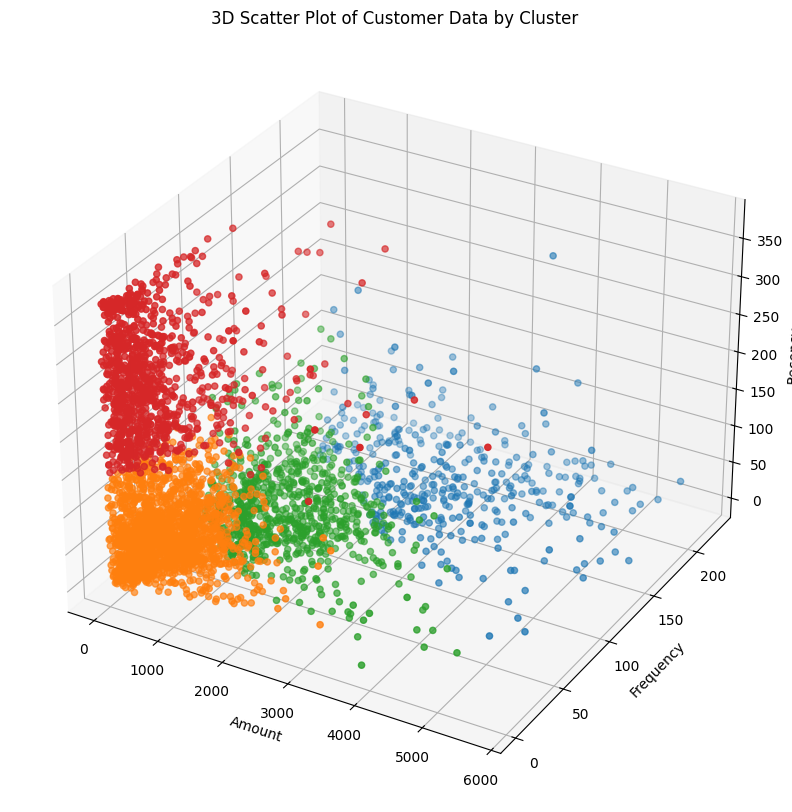

In [261]:
cluster_colors = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728'
}

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['Amount'], non_outliers_df['Frequency'], non_outliers_df['Recency'], c=colors, marker='o')

ax.set_xlabel('Amount')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

# Violin Plot

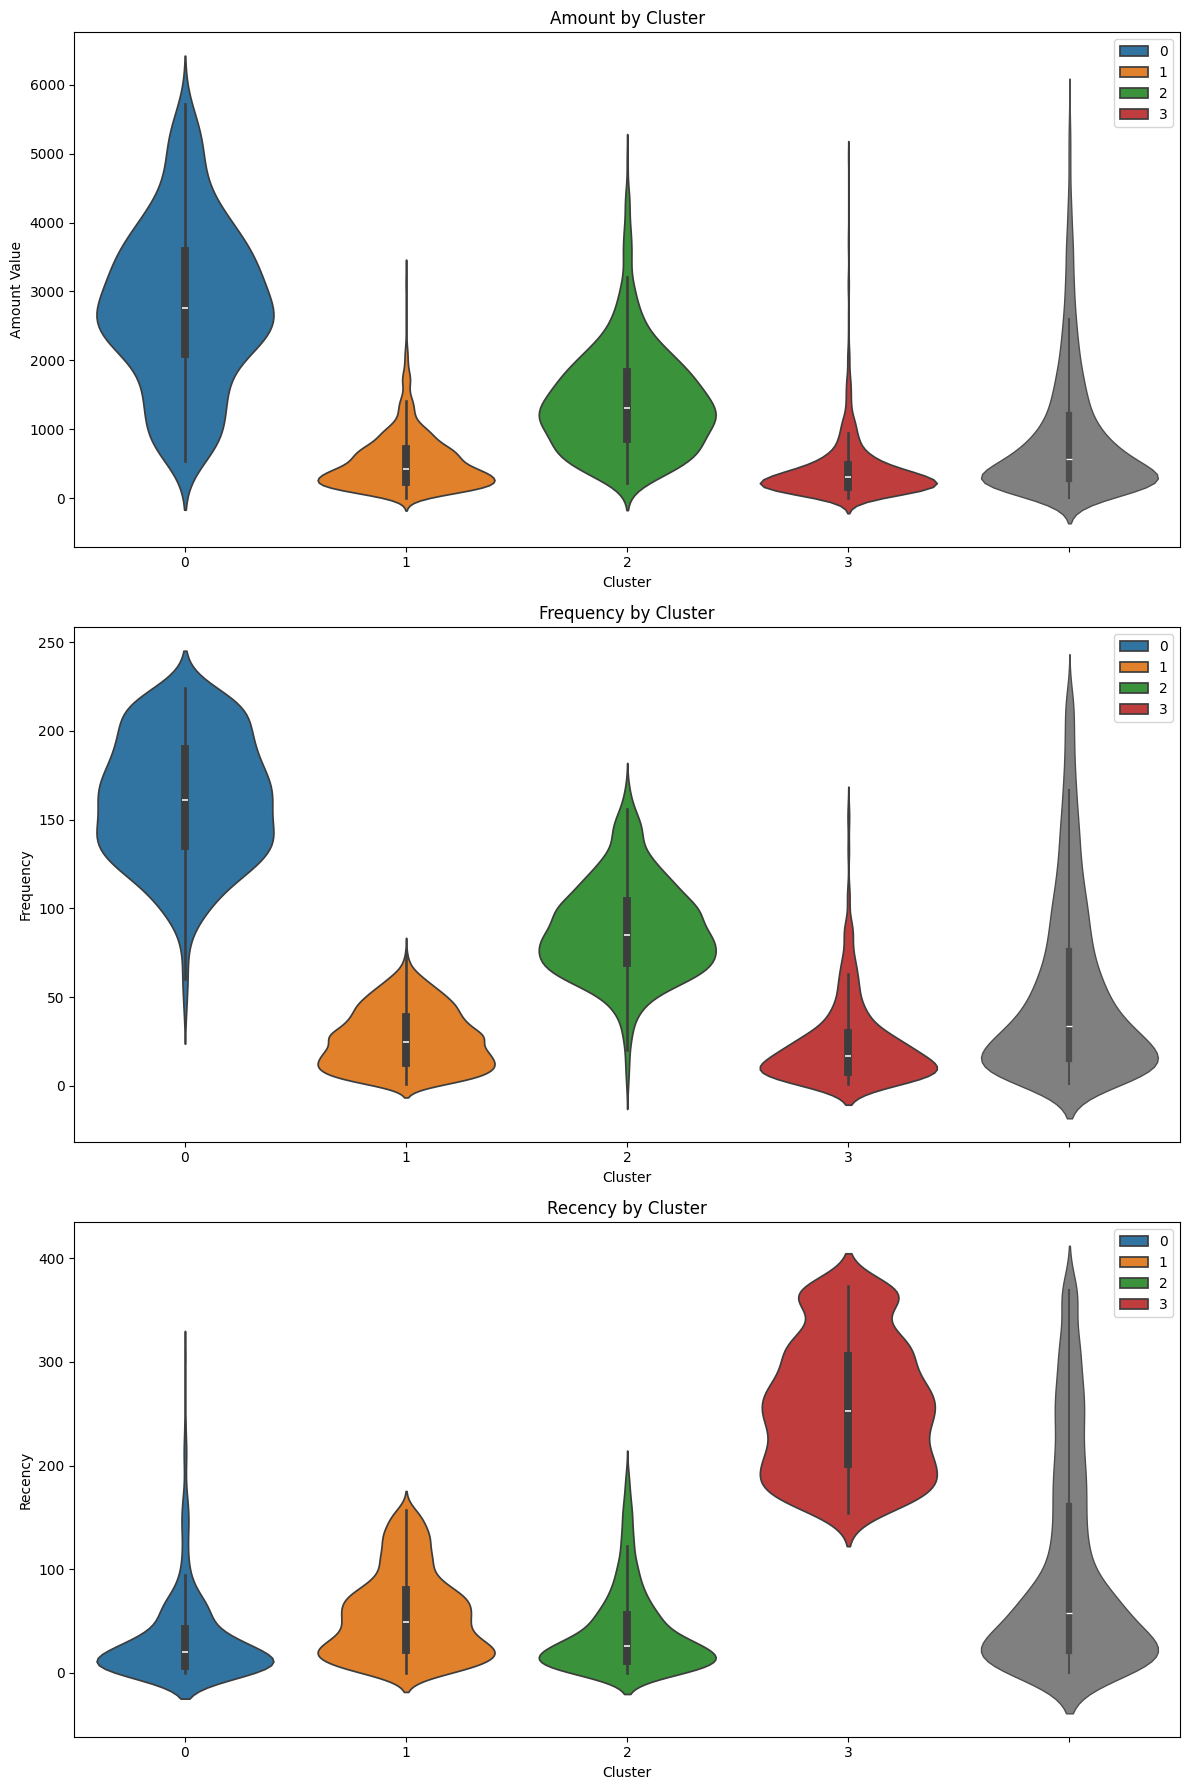

In [262]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Amount'], palette=cluster_colors, hue=non_outliers_df['Cluster'])
sns.violinplot(y=non_outliers_df['Amount'], color='gray', linewidth=1.0)
plt.title('Amount by Cluster')
plt.ylabel('Amount Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df['Cluster'])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df['Cluster'])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

# Violin with Outliers

## <span style="color: red;">Box Plots of Clusters created</span> 

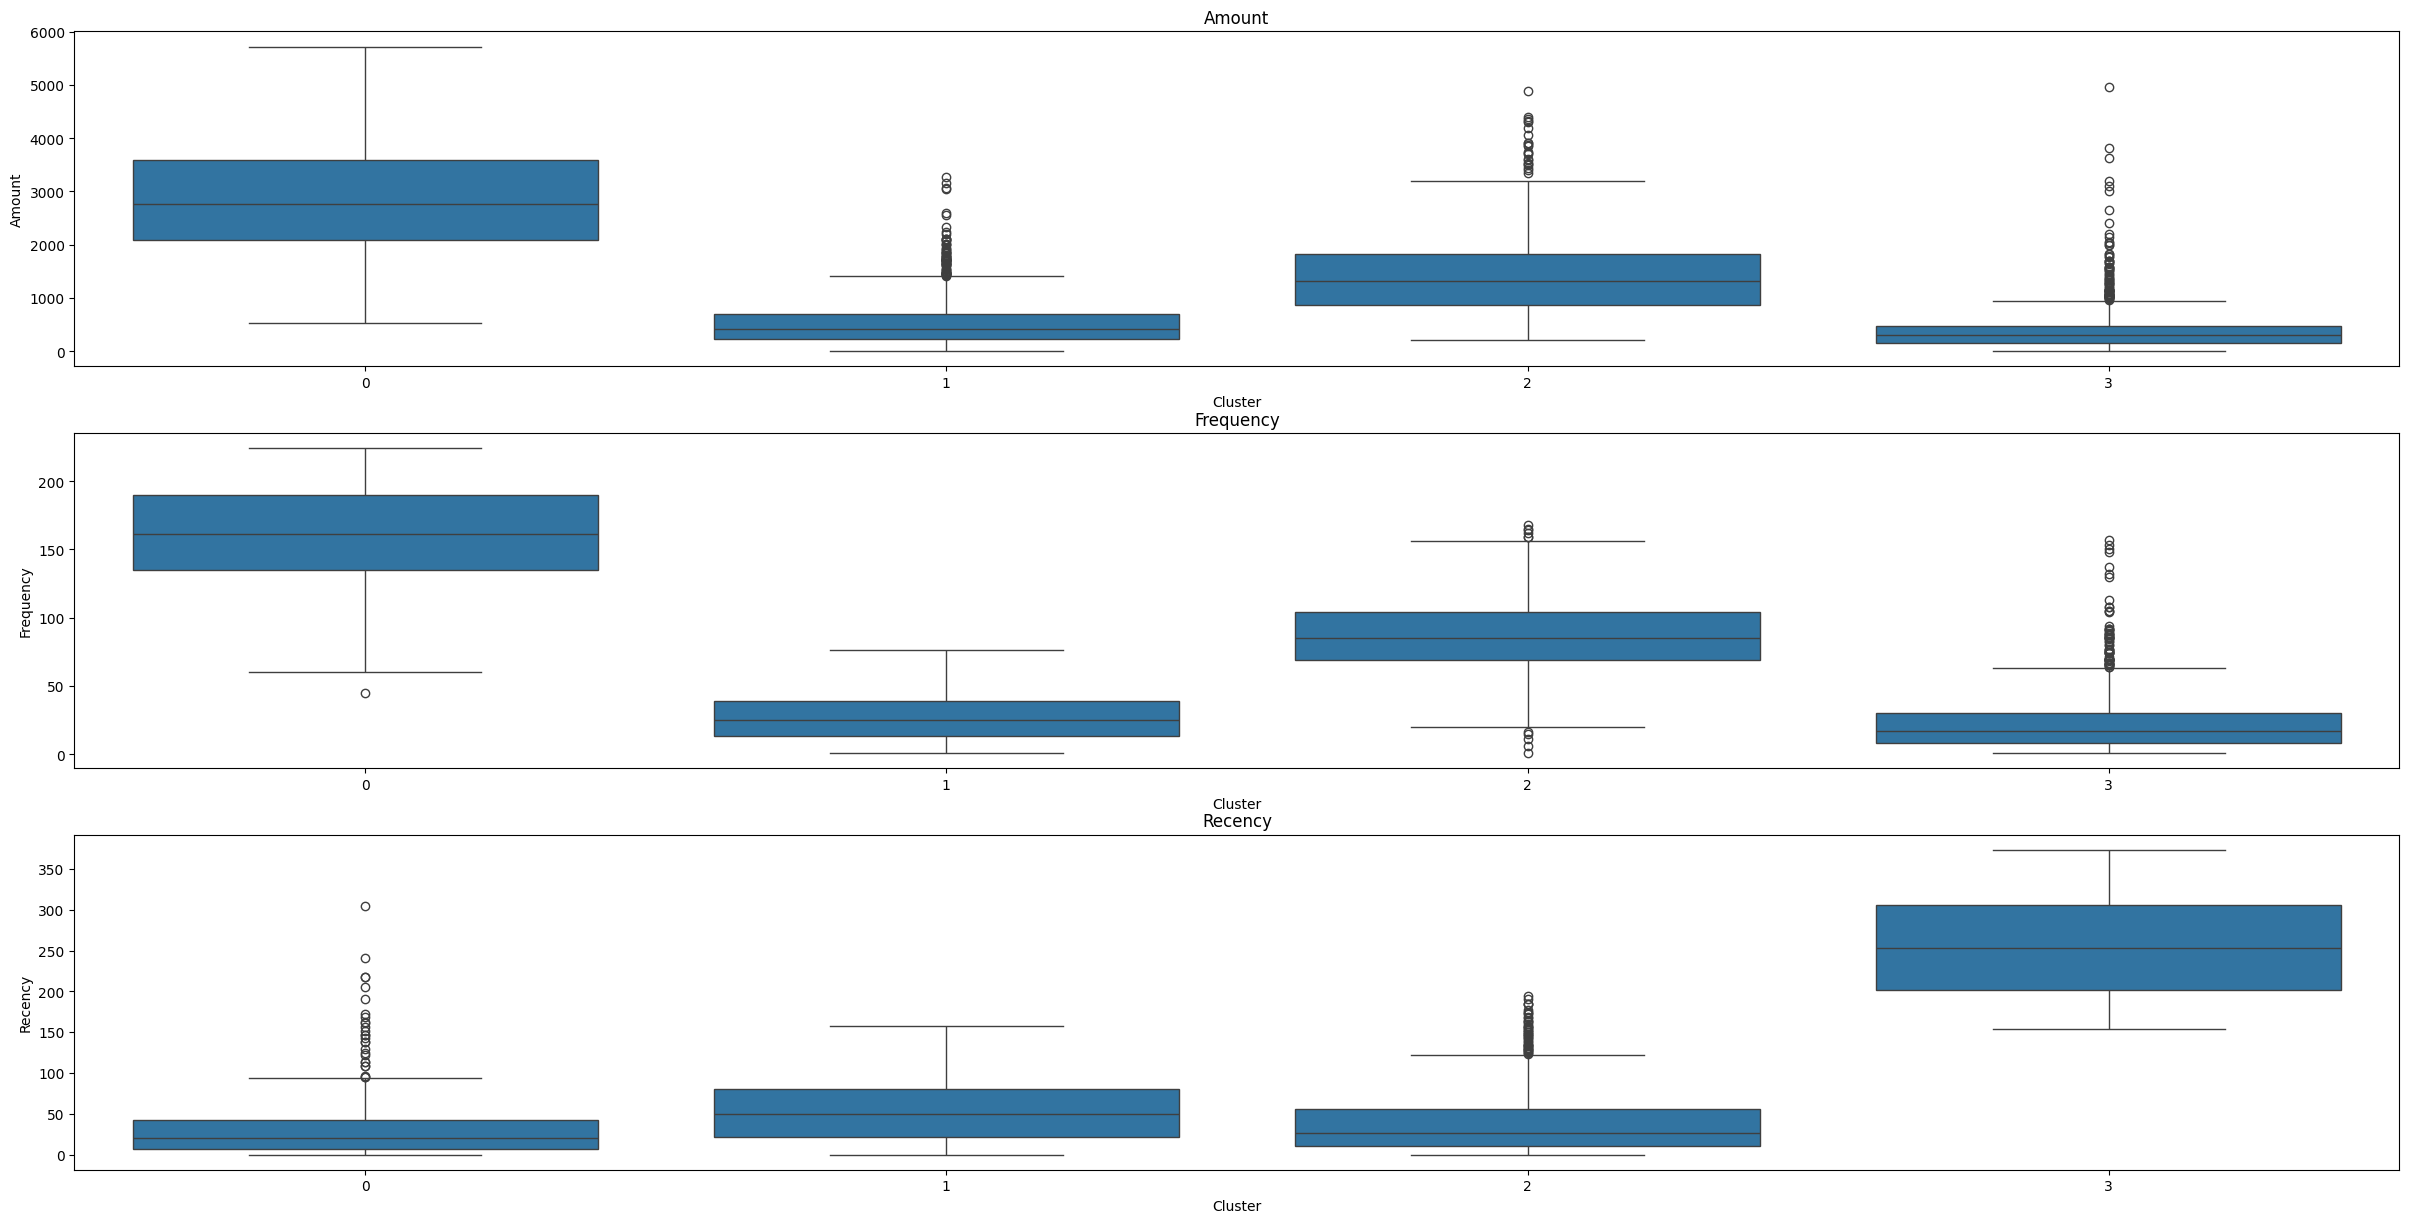

In [263]:
# Box plots of clusters created
plt.figure(figsize=(30, 20))

# Box plot for Amount
plt.subplot(4, 1, 1)
sns.boxplot(x='Cluster', y='Amount', data=non_outliers_df)
plt.title('Amount')

# Box plot for Frequency
plt.subplot(4, 1, 2)
sns.boxplot(x='Cluster', y='Frequency', data=non_outliers_df)
plt.title('Frequency')

# Box plot for Recency
plt.subplot(4, 1, 3)
sns.boxplot(x='Cluster', y='Recency', data=non_outliers_df)
plt.title('Recency')

plt.show()


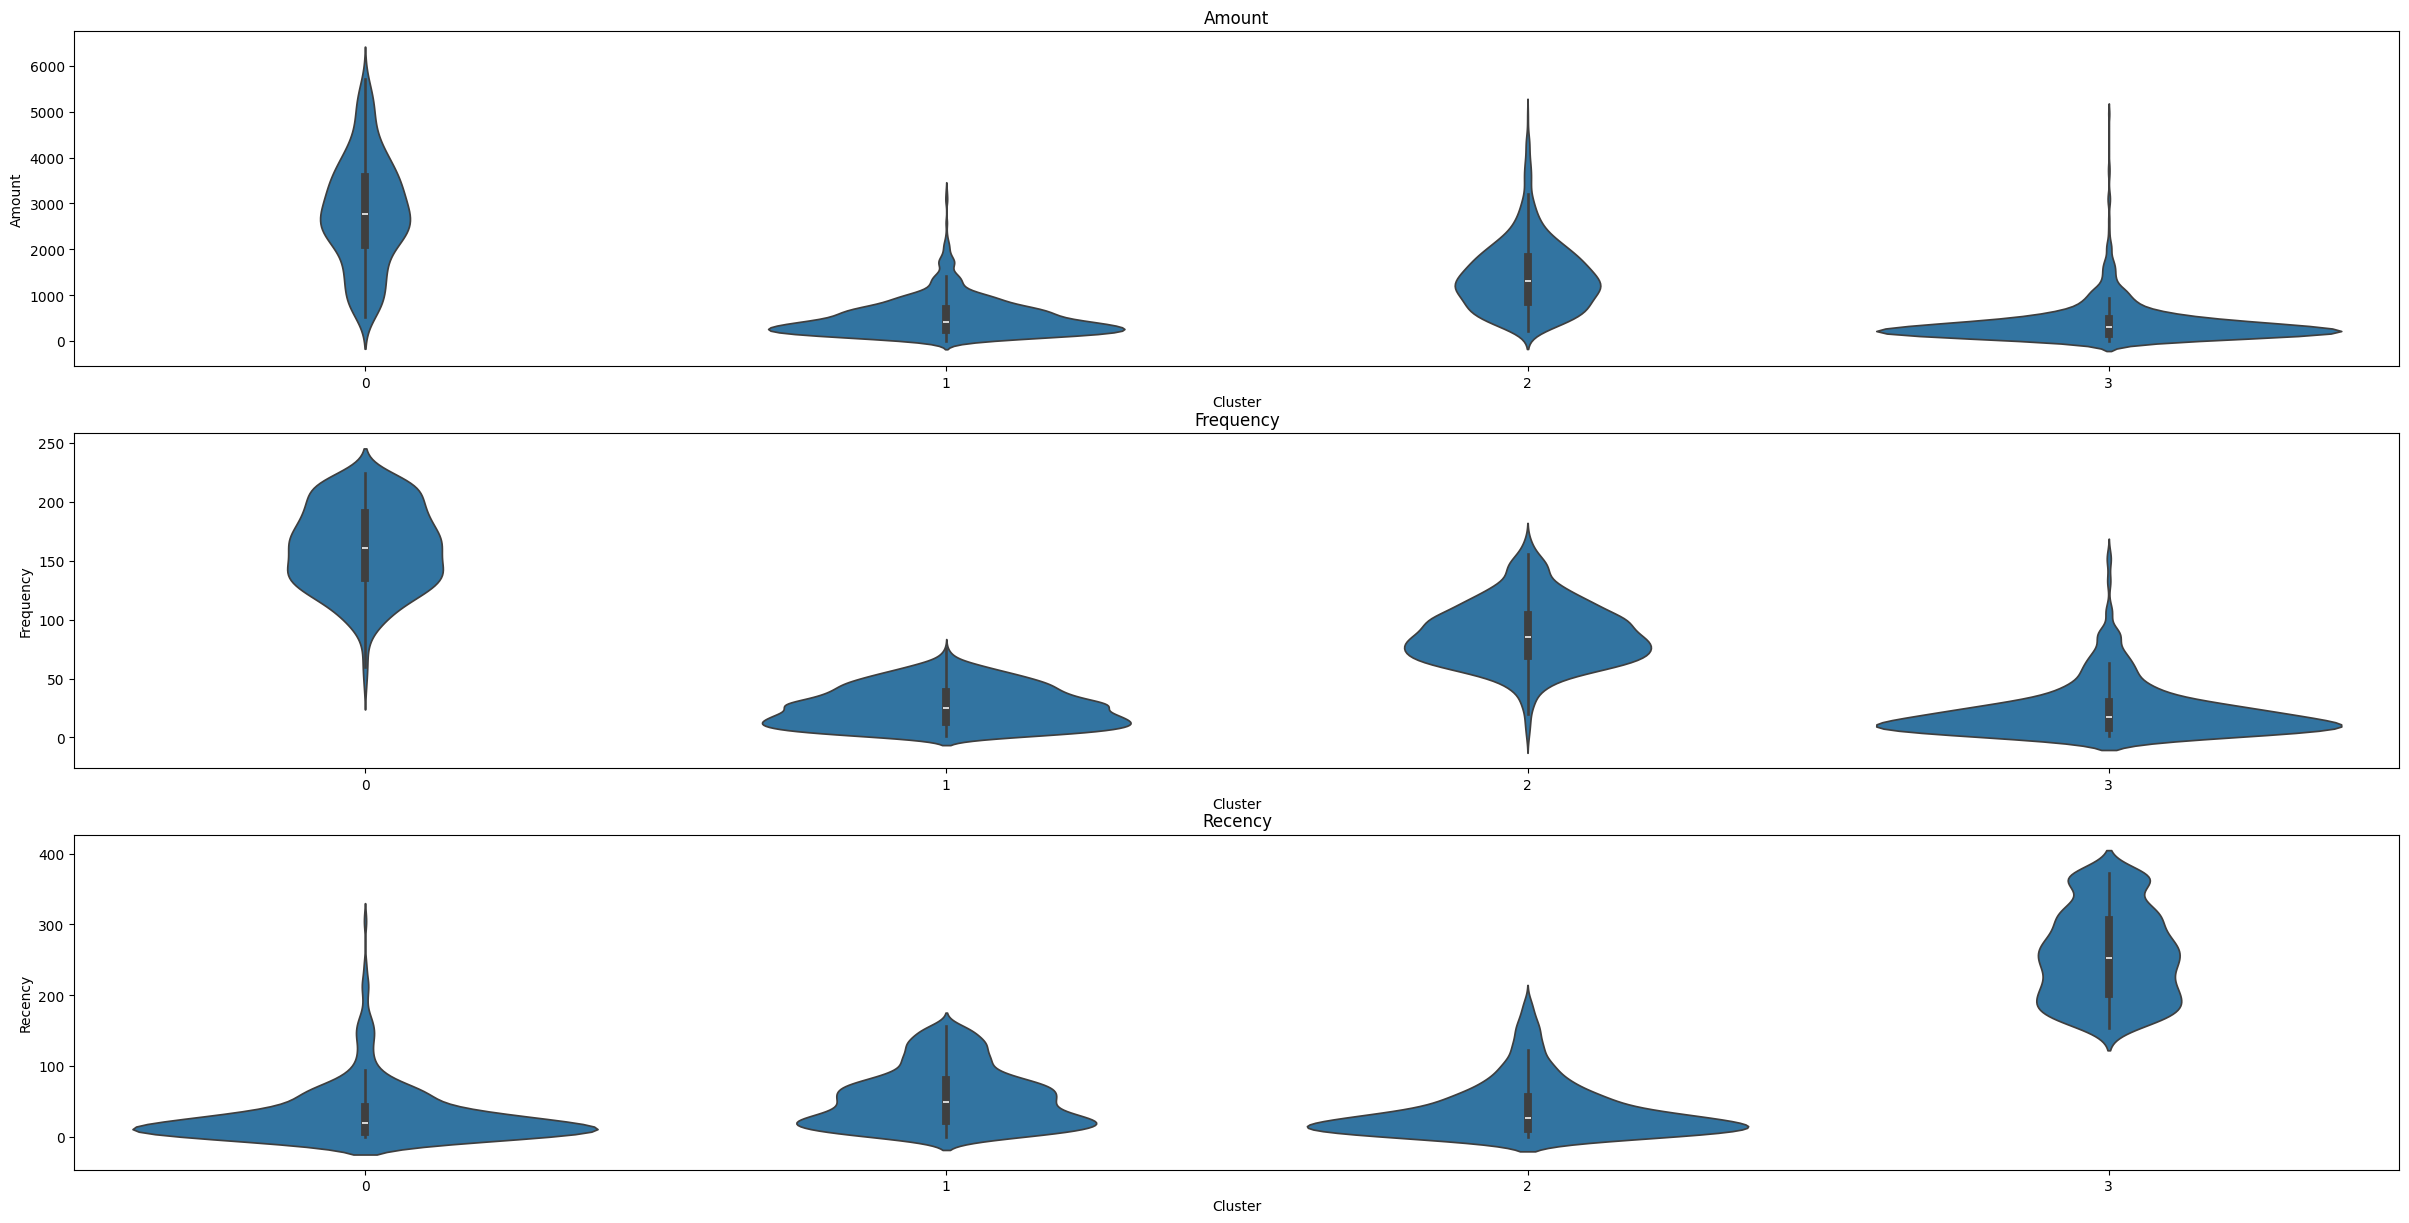

In [264]:
# Violin plots of clusters created
plt.figure(figsize=(30, 20))

# Violin plot for Amount
plt.subplot(4, 1, 1)
sns.violinplot(x='Cluster', y='Amount', data=non_outliers_df)
plt.title('Amount')

# Violin plot for Frequency
plt.subplot(4, 1, 2)
sns.violinplot(x='Cluster', y='Frequency', data=non_outliers_df)
plt.title('Frequency')

# Violin plot for Recency
plt.subplot(4, 1, 3)
sns.violinplot(x='Cluster', y='Recency', data=non_outliers_df)
plt.title('Recency')

plt.show()


In [265]:
overlap_indices = amount_outliers.index.intersection(frequency_outliers.index)

amount_only_outliers = amount_outliers.drop(overlap_indices)
frequency_only_outliers = frequency_outliers.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers.loc[overlap_indices]

amount_only_outliers['Cluster'] = -1
frequency_only_outliers['Cluster'] = -2
monetary_and_frequency_outliers['Cluster'] = -3

outlier_clusters = pd.concat([amount_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters

,CustomerID,Amount,Frequency,Recency,Cluster
0,12346.0,77183.60,1,325,-1
10,12357.0,6207.67,131,32,-1
50,12409.0,11072.67,109,78,-1
73,12435.0,7829.89,36,79,-1
105,12476.0,5898.42,224,15,-1
...,...,...,...,...,...
4025,17865.0,10524.22,369,30,-3
4161,18055.0,6784.19,360,6,-3
4197,18102.0,259657.30,431,0,-3
4202,18109.0,8052.97,444,1,-3


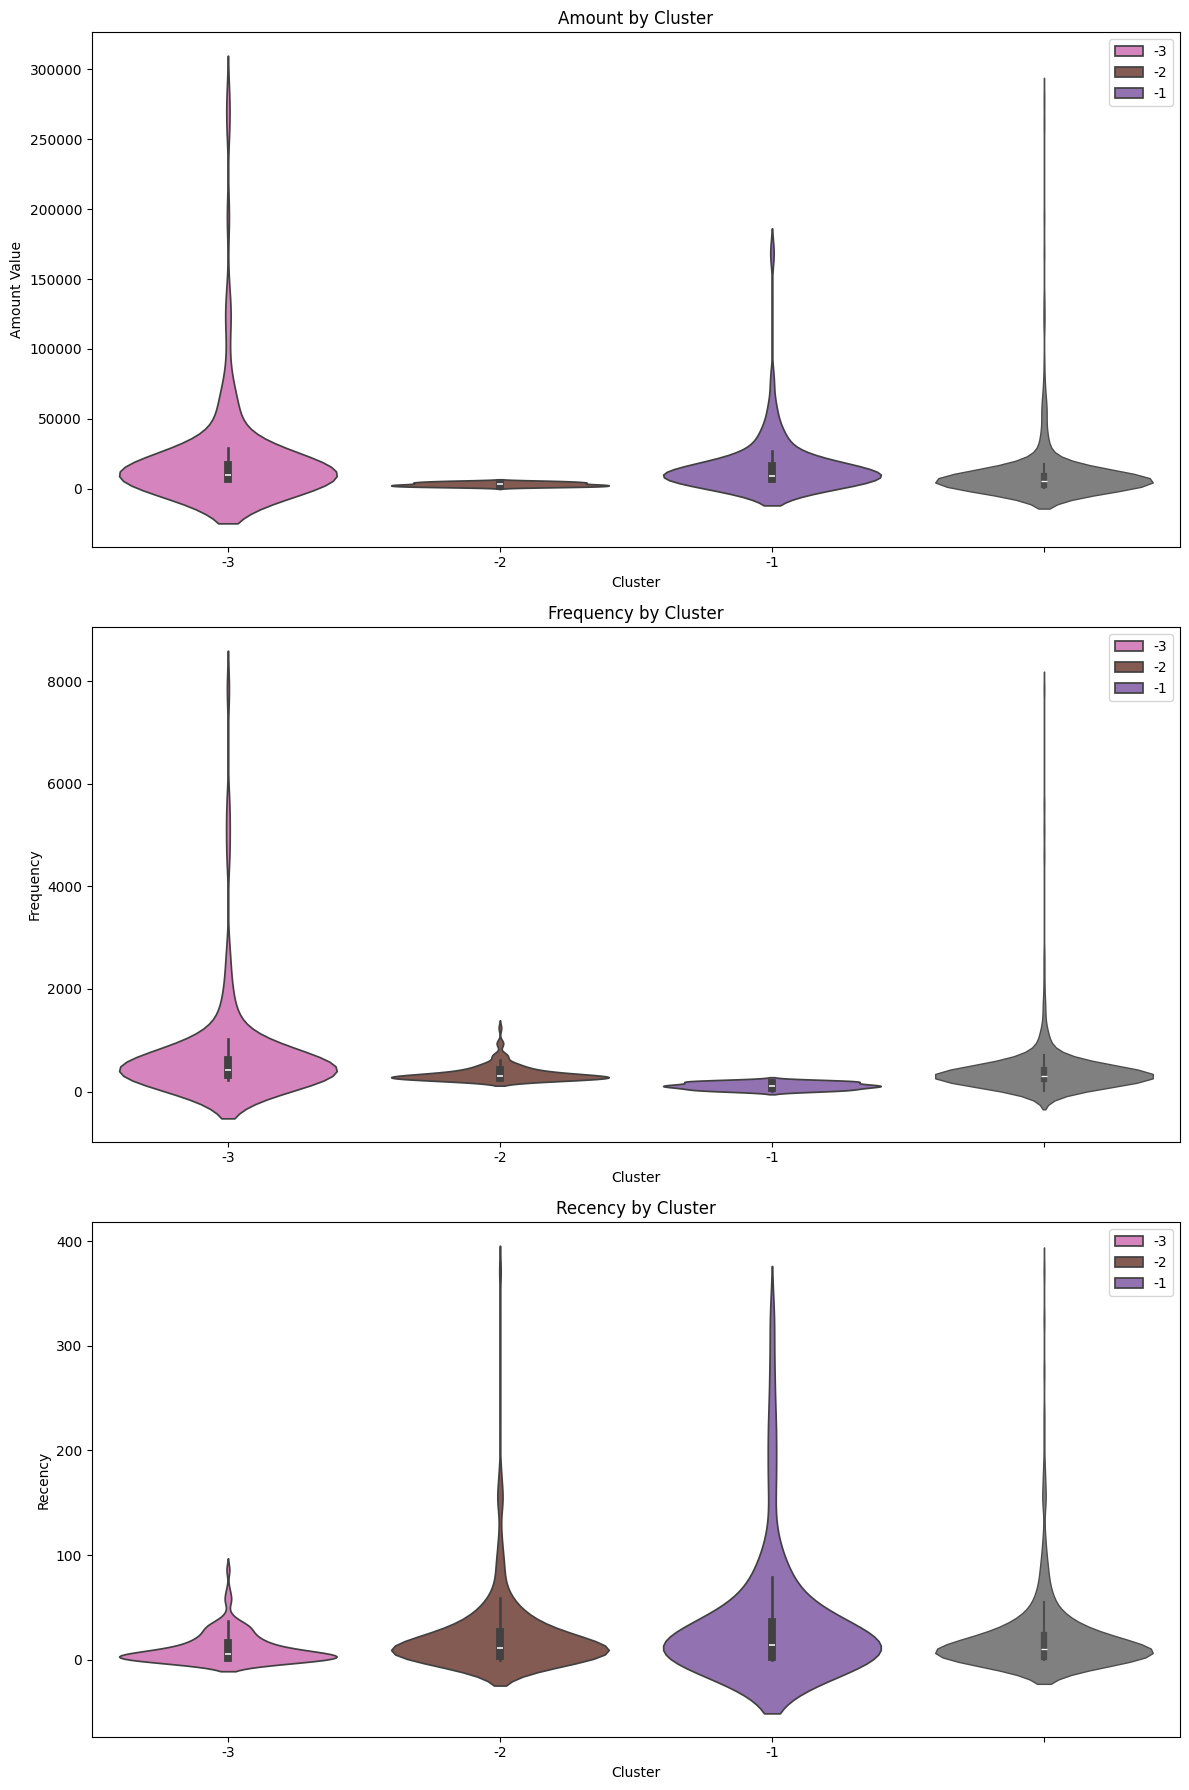

In [266]:
cluster_colors = {-1: '#9467bd', 
                    -2: '#8c564b', 
                    -3: '#e377c2'
                    }

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters['Cluster'], y=outlier_clusters['Amount'], palette=cluster_colors, hue=outlier_clusters['Cluster'])
sns.violinplot(y=outlier_clusters['Amount'], color='gray', linewidth=1.0)
plt.title('Amount by Cluster')
plt.ylabel('Amount Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters['Cluster'], y=outlier_clusters['Frequency'], palette=cluster_colors, hue=outlier_clusters['Cluster'])
sns.violinplot(y=outlier_clusters['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters['Cluster'], y=outlier_clusters['Recency'], palette=cluster_colors, hue=outlier_clusters['Cluster'])
sns.violinplot(y=outlier_clusters['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [275]:
cluster_labels = {
    0: "Big Spenders on Break",
    1: "Reliable Regulars",
    2: "Recent Bargain Hunters",
    3: "New Arrivals",
    -1: "VIP High Rollers",
    -2: "Occasional Shoppers",
    -3: "Big Spender Newcomers"
}

In [276]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters])

full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,CustomerID,Amount,Frequency,Recency,Cluster,ClusterLabel
1,12347.0,4310.00,182,1,0,Big Spenders on Break
2,12348.0,1437.24,27,74,1,Reliable Regulars
3,12349.0,1457.55,72,18,2,Recent Bargain Hunters
4,12350.0,294.40,16,309,3,New Arrivals
5,12352.0,1385.74,77,35,2,Recent Bargain Hunters
...,...,...,...,...,...,...
4025,17865.0,10524.22,369,30,-3,Big Spender Newcomers
4161,18055.0,6784.19,360,6,-3,Big Spender Newcomers
4197,18102.0,259657.30,431,0,-3,Big Spender Newcomers
4202,18109.0,8052.97,444,1,-3,Big Spender Newcomers


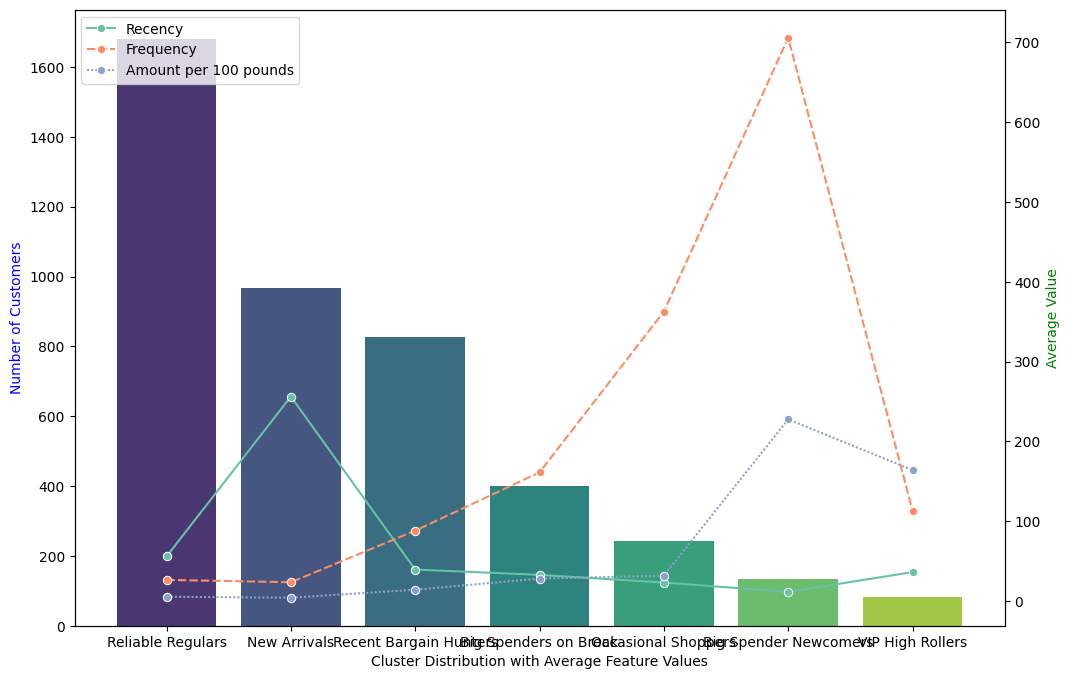

In [277]:
# volume of customer. get count per customer (Number of Customer)
cluster_counts = full_clustering_df["ClusterLabel"].value_counts()
# average of value
full_clustering_df["Amount per 100 pounds"] = full_clustering_df["Amount"] / 100.00
# get the mean of the features (Value)
feature_means = full_clustering_df.groupby(by="ClusterLabel")[['Recency', 'Frequency', 'Amount per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

# barplot for customers to get the count
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_xlabel('Cluster Distribution with Average Feature Values')

# twin axis
ax2 = ax1.twinx()

# represent feature means
sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

<a id="5"></a> <br>
## Step 5 : Final Analysis

## <span style="color: red;">Findings for customer archetypes (non-outliers)</span> 

Blue: (Big Spenders on Break)

- High-value, frequent customers who haven’t shopped recently. These are top shoppers but need a nudge to return.

- Highest in Amount (1st), indicating this group spends the most.

- Highest in Frequency (1st), meaning they also purchase most often.

- Lowest in Recency (4th), suggesting these customers are the least recent purchasers, perhaps loyal but not very active recently.

Green: (Reliable Regulars)

- Consistent buyers who spend a lot and shop often. The most dependable and engaged customers.

- Second in Amount (2nd), so they are high spenders.

- Second in Frequency (2nd), purchasing frequently.

- Fourth in Recency (4th), implying they made purchases somewhat recently but not the most recent.

Orange: (Recent Bargain Hunters)

- Customers who made recent purchases but don’t spend or shop frequently. They’re active but not yet high-value.

- Fourth in Amount (4th), spending relatively less.

- Fourth in Frequency (4th), buying less frequently.

- Second in Recency (2nd), suggesting they are recent customers but not big spenders or frequent buyers.

Red: (New Arrivals)

- The most recent customers, spending and purchasing the least. They might be new to purchasing or still exploring their buying habits.

- Lowest in Amount (5th), so they spend the least.

- Lowest in Frequency (5th), meaning they buy least often.

- Highest in Recency (1st), indicating they are the most recent customers, likely newer or less engaged.

## <span style="color: red;">Findings for customer archetypes (outliers)</span> 

Pink: (VIP High Rollers)

- These customers spend the most and buy frequently. Offering loyalty rewards or exclusive deals could increase profits from these top-tier shoppers.

Brown: (Occasional Shoppers)

- Medium spenders who shop occasionally but are very recent customers. Targeted promotions could encourage them to return and buy more frequently.

Purple: (Big Spender Newcomers)

- New customers who already spend a lot. Offering personalized promotions or product recommendations could help boost their shopping frequency and retention.

#### Student Names: 
- Aquino, Nathaniel
- Gayapa, Neal
- Gorospe, Roj
- Nicasio, Mark
- Santibanez, Luke
- Section: 4CSC